In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import itertools

In [3]:
dxy = dxy = yf.download('DX=F', start='2005-01-14', end='2025-01-01')[['Close', 'Volume']].reset_index()
dxy.columns = ['Date', 'DXY', 'Volume']
dxy

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,DXY,Volume
0,2005-01-14,83.129997,997
1,2005-01-18,83.459999,2007
2,2005-01-19,83.639999,2548
3,2005-01-20,83.930000,2264
4,2005-01-21,83.339996,1590
...,...,...,...
5021,2024-12-24,108.023003,0
5022,2024-12-26,107.892998,7276
5023,2024-12-27,107.792000,12300
5024,2024-12-30,107.932999,11951


In [4]:
aux = yf.download('GC=F', start='2005-01-01', end='2025-01-01')[['Close', 'Volume']].reset_index()
aux.columns = ['Date', 'GOLD', 'Volume']
aux

[*********************100%***********************]  1 of 1 completed


,Date,GOLD,Volume
0,2005-01-03,428.700012,4
1,2005-01-04,428.500000,108
2,2005-01-05,426.600006,2
3,2005-01-06,421.000000,1
4,2005-01-07,418.899994,1
...,...,...,...
5021,2024-12-24,2620.000000,35
5022,2024-12-26,2638.800049,84
5023,2024-12-27,2617.199951,642
5024,2024-12-30,2606.100098,794


# Data

## AUX

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
aux['aux_scaled'] = scaler.fit_transform(np.array(aux['GOLD']).reshape(-1, 1))
auxdf = aux[['Date', 'aux_scaled']].copy()

In [6]:
split_index = int(len(auxdf) * 0.8)

train_data = auxdf.iloc[:split_index]
test_data = auxdf.iloc[split_index:]

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (4020, 2)
test_data:  (1006, 2)


In [7]:
def create_dataset(data, time_step=15):
    X, y = [], []
    prices = data['aux_scaled'].values 

    for i in range(len(prices) - time_step):
        X.append(prices[i:i+time_step])      
        y.append(prices[i + time_step])       

    return np.array(X), np.array(y)

In [8]:
time_step = 15

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train:", X_train.shape) 
print("y_train:", y_train.shape)  
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (4005, 15)
y_train: (4005,)
X_test: (991, 15)
y_test: (991,)


## DXY

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
dxy['dxy_scaled'] = scaler.fit_transform(np.array(dxy['DXY']).reshape(-1, 1))
dxydf = dxy[['Date', 'dxy_scaled']].copy()

In [10]:
train_data_dxy = dxydf.iloc[:split_index]
test_data_dxy = dxydf.iloc[split_index:]

train_data_dxy = train_data_dxy.reset_index(drop=True)
test_data_dxy = test_data_dxy.reset_index(drop=True)
print("train_data_dxy: ", train_data_dxy.shape)
print("test_data_dxy: ", test_data_dxy.shape)

train_data_dxy:  (4020, 2)
test_data_dxy:  (1006, 2)


In [11]:
def create_dataset_dxy(data, time_step=15):
    X, y = [], []
    prices = data['dxy_scaled'].values 

    for i in range(len(prices) - time_step):
        X.append(prices[i:i+time_step])      
        y.append(prices[i + time_step])       

    return np.array(X), np.array(y)

In [12]:
time_step = 15

X_train_dxy, y_train_dxy = create_dataset_dxy(train_data_dxy, time_step)
X_test_dxy, y_test_dxy = create_dataset_dxy(test_data_dxy, time_step)

print("X_train_dxy:", X_train_dxy.shape) 
print("y_train_dxy:", y_train_dxy.shape)  
print("X_test_dxy:", X_test_dxy.shape)
print("y_test_dxy:", y_test_dxy.shape)

X_train_dxy: (4005, 15)
y_train_dxy: (4005,)
X_test_dxy: (991, 15)
y_test_dxy: (991,)


# RF

In [13]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 1200,max_depth = 6, min_samples_split = 2, random_state = 42)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=1200, random_state=42)

In [14]:
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (4005, 1)
Test data prediction: (991, 1)


In [15]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

Text(0.5, 1.0, 'AUX Closing Value')

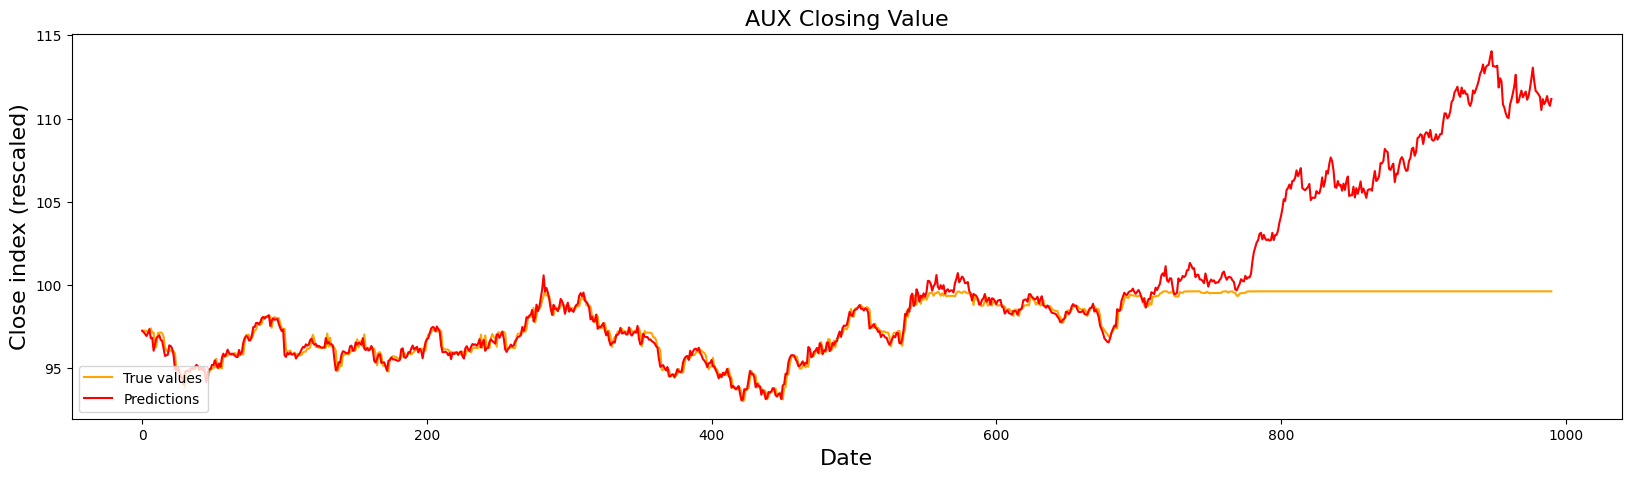

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(test_predict, c='orange', label='True values',)
plt.plot(original_ytest, c='r', linestyle='-', label='Predictions')
plt.legend(loc="lower left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close index (rescaled)", fontsize=16)
plt.title("AUX Closing Value", fontsize=16)

# KNN

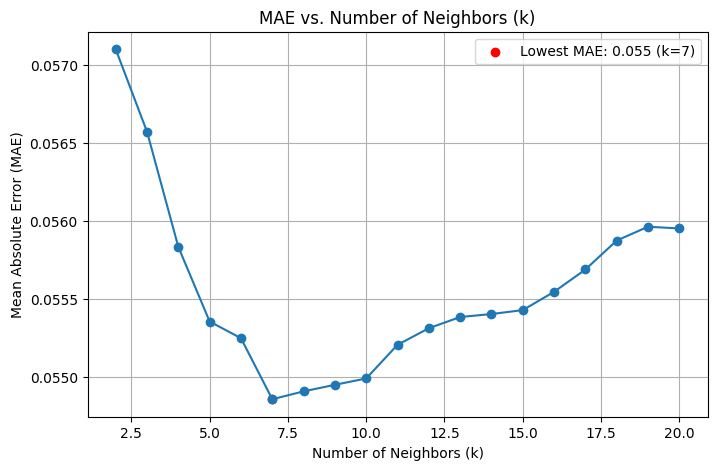

In [17]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

mae_scores = []

for k in range(2, 21):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

# Find best k (lowest MAE)
best_k = range(2, 21)[mae_scores.index(min(mae_scores))]
best_mae = min(mae_scores)

# Plot MAE vs k
plt.figure(figsize=(8,5))
plt.plot(range(2, 21), mae_scores, marker='o')
plt.scatter(best_k, best_mae, color='red', label=f'Lowest MAE: {best_mae:.3f} (k={best_k})')
plt.title('MAE vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [19]:
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (4005, 1)
Test data prediction: (991, 1)


In [20]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

Text(0.5, 1.0, 'AUX Closing Value')

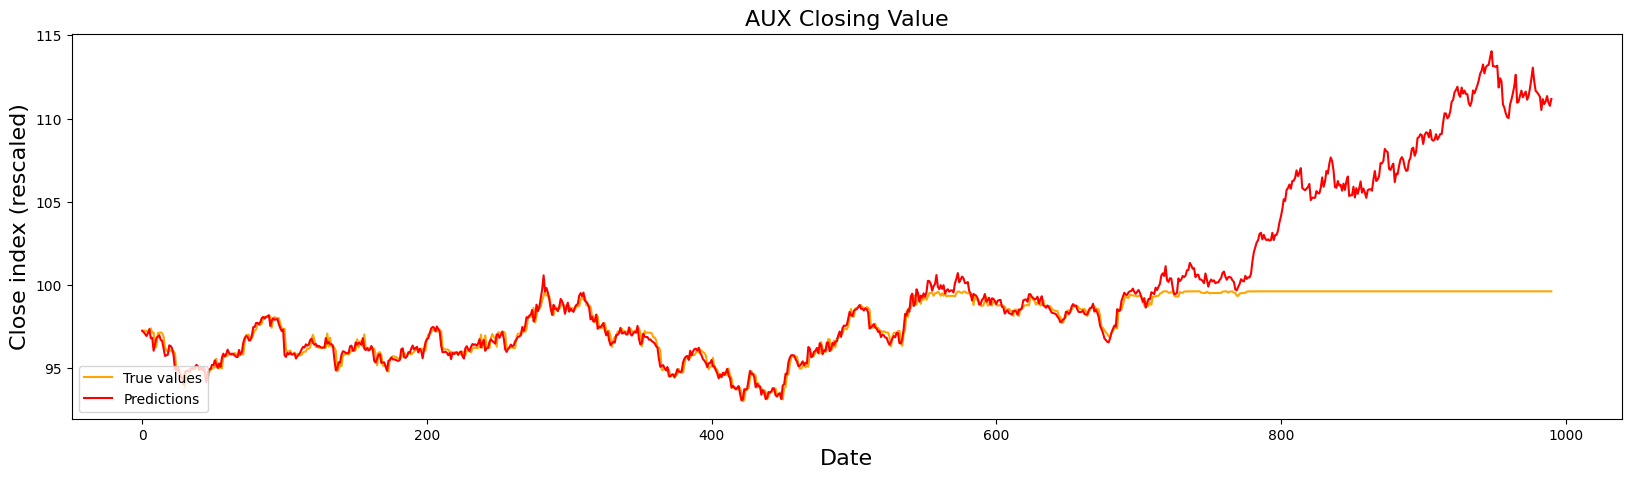

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(test_predict, c='orange', label='True values',)
plt.plot(original_ytest, c='r', linestyle='-', label='Predictions')
plt.legend(loc="lower left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close index (rescaled)", fontsize=16)
plt.title("AUX Closing Value", fontsize=16)

# Gradient Boost

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=1000, random_state=42)

In [23]:
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (4005, 1)
Test data prediction: (991, 1)


In [24]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

Text(0.5, 1.0, 'AUX Closing Value')

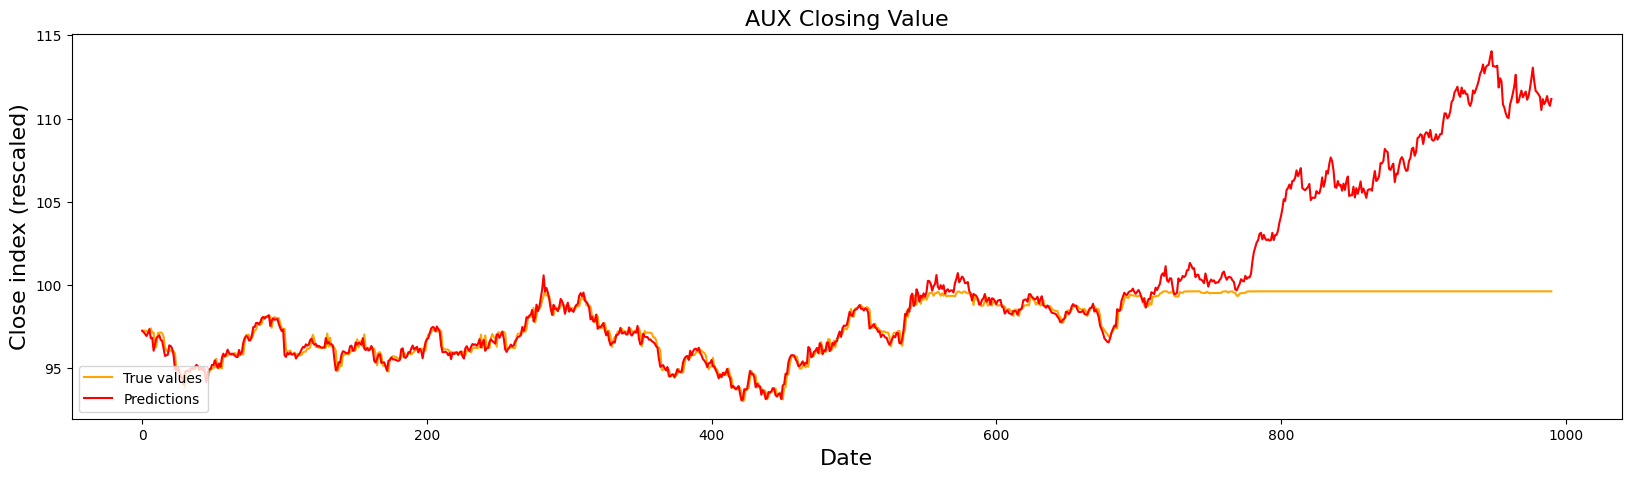

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(test_predict, c='orange', label='True values',)
plt.plot(original_ytest, c='r', linestyle='-', label='Predictions')
plt.legend(loc="lower left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close index (rescaled)", fontsize=16)
plt.title("AUX Closing Value", fontsize=16)

# Change points

Change points detected at indices: [680, 1215, 1570, 2080, 3770, 4820, 5026]


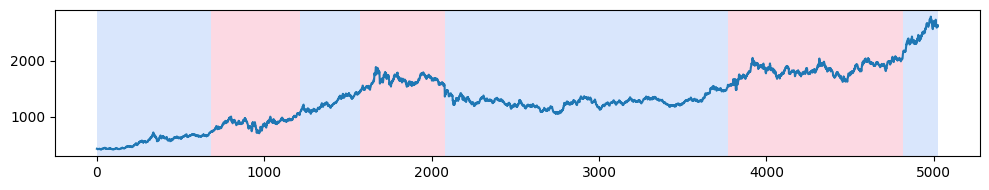

In [26]:
import ruptures as rpt

algo = rpt.Pelt(model="rbf").fit(aux['GOLD'].values)
change_points = algo.predict(pen=100)  

print("Change points detected at indices:", change_points)

# Plot results
rpt.display(aux['GOLD'].values, change_points)
plt.show()

Change points detected at indices: [550, 2485, 4340, 5026]


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

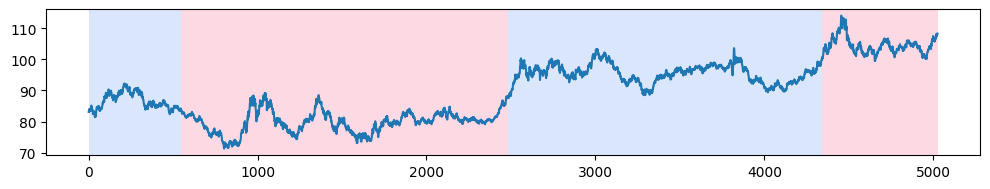

In [27]:
algo = rpt.Pelt(model="rbf").fit(dxy['DXY'].values)
change_points = algo.predict(pen=100)  

print("Change points detected at indices:", change_points)

# Plot results
rpt.display(dxy['DXY'].values, change_points)

Change points detected at indices: [535, 785, 991]


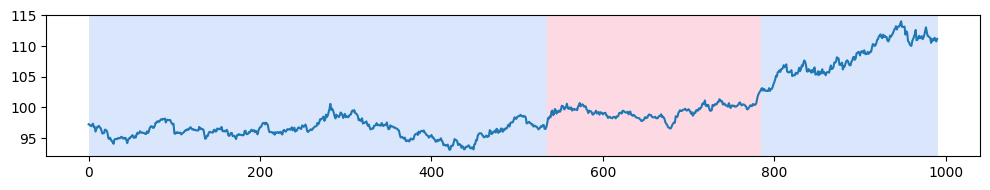

In [28]:
import ruptures as rpt

algo = rpt.Pelt(model="rbf").fit(original_ytest.reshape(-1))
change_points = algo.predict(pen=60)  

print("Change points detected at indices:", change_points)

# Plot results
rpt.display(original_ytest.reshape(-1), change_points)
plt.show()

Change points detected at indices: [535, 785, 895, 991]


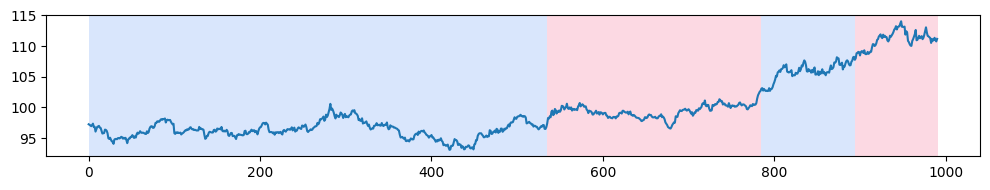

In [29]:
import ruptures as rpt

algo = rpt.Pelt(model="rbf").fit(original_ytest.reshape(-1))
change_points = algo.predict(pen=50)  

print("Change points detected at indices:", change_points)

# Plot results
rpt.display(original_ytest.reshape(-1), change_points)
plt.show()

Change points detected at indices: [200, 310, 395, 455, 991]


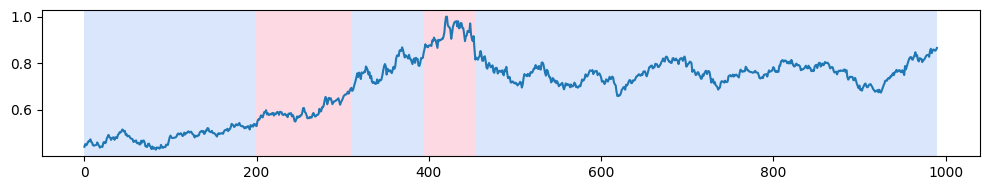

In [30]:
algo = rpt.Pelt(model="rbf").fit(y_test_dxy.reshape(-1))
change_points = algo.predict(pen=30)  

print("Change points detected at indices:", change_points)

# Plot results
rpt.display(y_test_dxy.reshape(-1), change_points)
plt.show()

# Correction

In [31]:
base_pred = knn.predict(X_test)
residual = y_test - base_pred

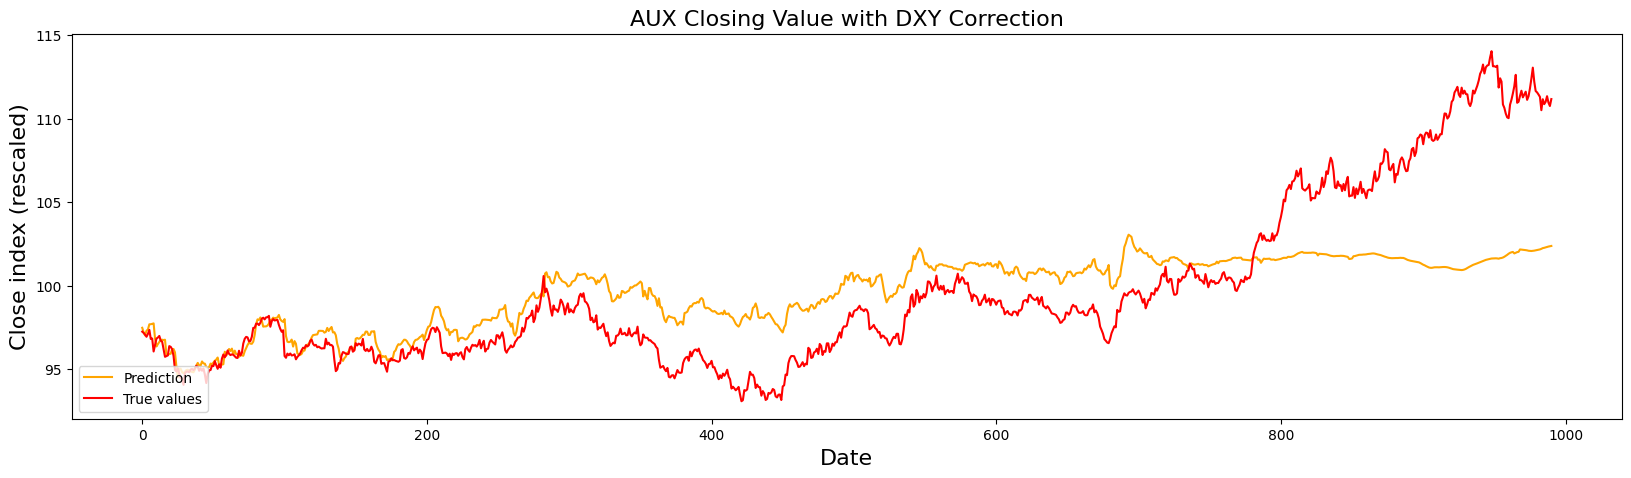

In [32]:
from sklearn.linear_model import Ridge
correction_model = Ridge()
correction_model.fit(X_test_dxy, residual)
correction = correction_model.predict(X_test_dxy)
final_pred = base_pred + correction
final_pred_inv = scaler.inverse_transform(final_pred.reshape(-1, 1))
plt.figure(figsize=(20, 5))
plt.plot(final_pred_inv, c='orange', label='Prediction')
plt.plot(original_ytest, c='r', linestyle='-', label='True values')
plt.legend(loc="lower left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close index (rescaled)", fontsize=16)
plt.title("AUX Closing Value with DXY Correction", fontsize=16)
plt.show()

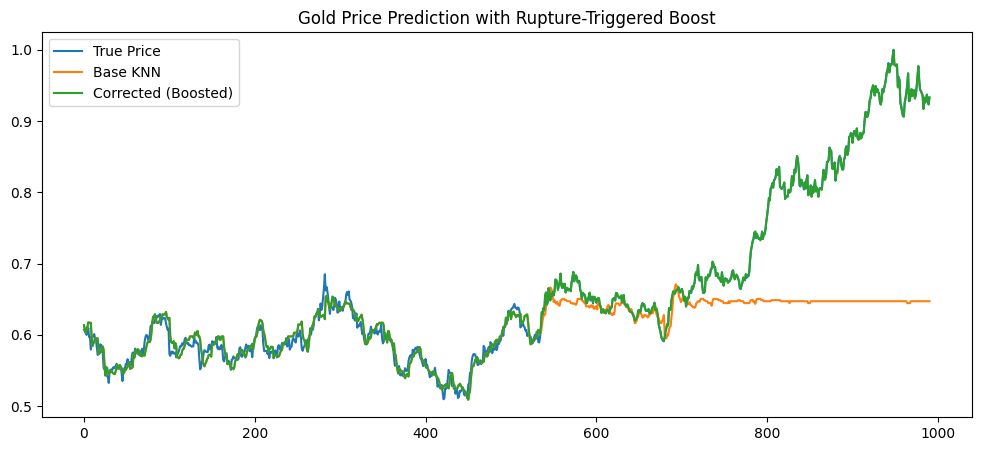

In [33]:
base_pred = knn.predict(X_test)
residual = y_test - base_pred
algo = rpt.Pelt(model="rbf").fit(y_test.reshape(-1, 1))
change_points = algo.predict(pen=50)

boost_mask = np.zeros_like(base_pred, dtype=bool)
for cp in change_points:
    if cp < len(base_pred):
        boost_mask[cp:] = True

X_boost = X_test_dxy[boost_mask]
y_boost = residual[boost_mask]

gbr.fit(X_boost, y_boost)
correction = np.zeros_like(base_pred)
correction[boost_mask] = gbr.predict(X_boost)

final_pred = base_pred + correction

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='True Price')
plt.plot(base_pred, label='Base KNN')
plt.plot(final_pred, label='Corrected (Boosted)')
plt.legend()
plt.title("Gold Price Prediction with Rupture-Triggered Boost")
plt.show()

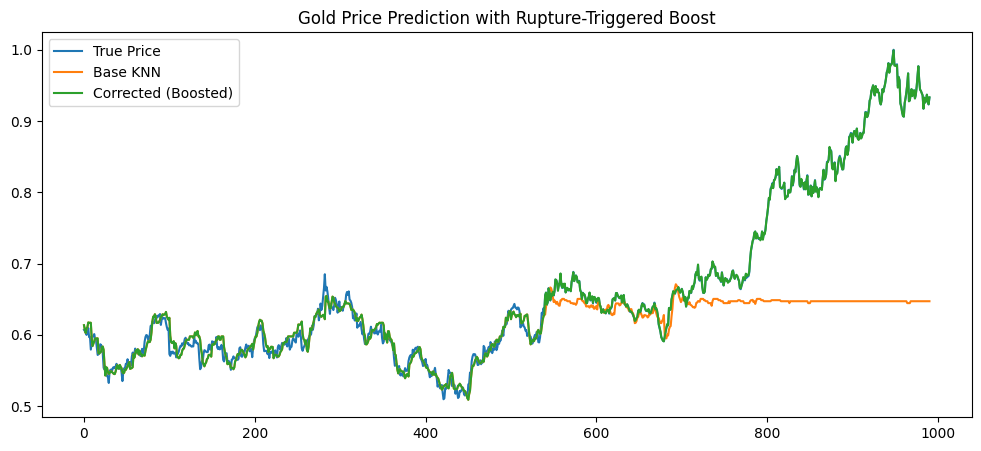

In [36]:
base_pred = knn.predict(X_test)
residual = y_test - base_pred
algo = rpt.Pelt(model="rbf").fit(base_pred.reshape(-1, 1))
change_points = algo.predict(pen=50)

boost_mask = np.zeros_like(base_pred, dtype=bool)
for cp in change_points:
    if cp < len(base_pred):
        boost_mask[cp:] = True

X_boost = X_test_dxy[boost_mask]
y_boost = residual[boost_mask]

gbr.fit(X_boost, y_boost)
correction = np.zeros_like(base_pred)
correction[boost_mask] = gbr.predict(X_boost)

final_pred = base_pred + correction

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='True Price')
plt.plot(base_pred, label='Base KNN')
plt.plot(final_pred, label='Corrected (Boosted)')
plt.legend()
plt.title("Gold Price Prediction with Rupture-Triggered Boost")
plt.show()